<a href="https://colab.research.google.com/github/SrijithBalachander/Vietnamese_HTR/blob/main/HTR_vn_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vietnamese HTR

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing from Kaggle

Skip if previously done

In [ ]:
!pip install kaggle

In [ ]:
%cd "/content/drive/MyDrive/Kaggle"

In [ ]:
!kaggle datasets download -d bomaich/vietnamese-handwritten-ocr

In [ ]:
!mkdir vietnamese_handwritten_ocr
!unzip -q vietnamese-handwritten-ocr.zip -d vietnamese_handwritten_ocr/

In [ ]:
!ls vietnamese_handwritten_ocr/

In [ ]:
%cd /content

## Importing packages

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [3]:
import os
import cv2
import re

In [4]:
import string
import time

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, KFold,StratifiedKFold 

In [5]:
from PIL import Image
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

## Getting Data from Drive for processing

Copying processed VNonDB word dataset from drive for further processing into train, valid and test data. The VNonDB word dataset was originally in INKML format which has been converted to corresponding image and label files.

In [6]:
%cp "/content/drive/MyDrive/InkData_word_processed_resized.zip" .
%cp "/content/drive/MyDrive/InkData_word_labels.zip" .

In [7]:
!wget https://raw.githubusercontent.com/SrijithBalachander/Vietnamese_HTR/main/data_split/test_set.txt
!wget https://raw.githubusercontent.com/SrijithBalachander/Vietnamese_HTR/main/data_split/validation_set.txt
!wget https://raw.githubusercontent.com/SrijithBalachander/Vietnamese_HTR/main/data_split/train_set.txt

--2022-06-09 20:48:00--  https://raw.githubusercontent.com/SrijithBalachander/Vietnamese_HTR/main/data_split/test_set.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1783 (1.7K) [text/plain]
Saving to: ‘test_set.txt’

test_set.txt        100%[===================>]   1.74K  --.-KB/s    in 0s      

2022-06-09 20:48:00 (12.4 MB/s) - ‘test_set.txt’ saved [1783/1783]

--2022-06-09 20:48:01--  https://raw.githubusercontent.com/SrijithBalachander/Vietnamese_HTR/main/data_split/validation_set.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [ ]:
# !pip install patool
# import patoolib

In [ ]:
# %mkdir "InkData_word_processed/"
# patoolib.extract_archive("InkData_word_processed.rar", outdir="InkData_word_processed/")

In [8]:
!unzip -q InkData_word_processed_resized.zip
!unzip -q InkData_word_labels.zip

## Split into Train, Valid and Test

In [9]:
def pil_resize(image):
  # image = Image.open(all_paths[file])
  # image = np.asarray(image)
  # right = 100
  # left = 100
  # top = 100
  # bottom = 100
    
  width, height = image.size
  new_width,new_height = image.size

  if width < 128:
    new_width = width + (128-width)
  if height < 32:
    new_height = height + (32-height)

  result = Image.new(image.mode, (new_width, new_height), (255))

  result.paste(image, ((new_width-width)//2, (new_height-height)//2))

  return np.array(result)

In [10]:
char_encoding = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvxyzÀÁÂÔÚÝàáâãèéêìíòóôõùúýĂăĐđĩũƒƠơƯưạẢảẤấẦầẩẫậắằẳẵặẹẻẽếỀềỂểễỆệỉịọỏỐốỒồổỗộớờỞởỡợụỦủứừửữựỳỷỹ'
print ('the number of characters:', len(char_encoding))
max_len_label = 0

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_encoding.index(char))
        except:
            print(char)
        
    return dig_lst

the number of characters: 147


In [11]:
X_train = []
X_valid = []
X_test = []
y_train = []
y_valid = []
y_test = []

y_train_enc = []
train_input_len = []
y_train_len = []
y_valid_enc = []
valid_input_len = []
y_valid_len = []

images_path = "InkData_word_processed_resized"
labels_path = "InkData_word_labels"

# os.chdir("InkData_word_processed_resized")

label_files = os.listdir(labels_path)

with open("/content/train_set.txt", "r") as file:
  for value in file:
    value = value.split(".")[0]
    for filename in label_files:
      filename = filename.split(".")[0]
      if value in filename:
        image = cv2.cvtColor(cv2.imread(os.path.join(images_path,filename+".png")),cv2.COLOR_BGR2GRAY)
        # image = Image.open(os.path.join(images_path,filename[0]+".png"))
        # image = pil_resize(image)
        # image = cv2.resize(image, (128,32))
        image = image/255.
        image = np.expand_dims(image, axis=2)
        X_train.append(image)
        with open(os.path.join(labels_path,filename+".txt"), "r") as label_file:
          # print(label_file)
          for label in label_file:
          # label = label_file[0].strip()
            y_train.append(label)
            y_train_enc.append(encode_to_labels(label))
            y_train_len.append(len(label))
            train_input_len.append(31)
            max_len_label = max(max_len_label,len(label))

with open("/content/validation_set.txt", "r") as file:
  for value in file:
    value = value.split(".")[0]
    for filename in label_files:
      filename = filename.split(".")[0]
      if value in filename:
        image = cv2.cvtColor(cv2.imread(os.path.join(images_path,filename+".png")),cv2.COLOR_BGR2GRAY)
        # image = Image.open(os.path.join(images_path,filename[0]+".png"))
        # image = pil_resize(image)
        # image = cv2.resize(image, (128,32))
        image = image/255.
        image = np.expand_dims(image, axis=2)
        X_valid.append(image)
        with open(os.path.join(labels_path,filename+".txt"), "r") as label_file:
          # print(label_file)
          for label in label_file:
          # label = label_file[0].strip()
            y_valid.append(label)
            y_valid_enc.append(encode_to_labels(label))
            y_valid_len.append(len(label))
            valid_input_len.append(31)
            max_len_label = max(max_len_label,len(label))


with open("/content/test_set.txt", "r") as file:
  for value in file:
    value = value.split(".")[0]
    for filename in label_files:
      filename = filename.split(".")[0]
      if value in filename:
        image = cv2.cvtColor(cv2.imread(os.path.join(images_path,filename+".png")),cv2.COLOR_BGR2GRAY)
        # image = Image.open(os.path.join(images_path,filename[0]+".png"))
        # image = pil_resize(image)
        # image = cv2.resize(image, (128,32))
        image = image/255.
        image = np.expand_dims(image, axis=2)
        X_test.append(image)
        with open(os.path.join(labels_path,filename+".txt"), "r") as label_file:
          # print(label_file)
          for label in label_file:
          # label = label_file[0].strip()
            y_test.append(label)
            max_len_label = max(max_len_label,len(label))

label_files = []    ## stopping RAM from exploding

# with open("/content/test_set.txt", "r") as file:
#   for value in file:
#     value = value.split(".")[0]
#     for filename in os.listdir():
#       if(filename == "InkData_word_processed_resized"):
#         continue
#       filename = filename.split(".")
#       if filename[1] == "png" and value in filename[0]:
#         image = Image.open(filename[0]+".png")
#         image = pil_resize(image)
#         image = cv2.resize(image, (128,32))
#         image = image/255.
#         image = np.expand_dims(image, axis=2)
        
#         X_test.append(image)
#         with open(filename[0]+".txt", "r") as label_file:
#           for label in label_file:
#             y_test.append(label)
#             max_len_label = max(max_len_label,len(label))

# with open("/content/validation_set.txt", "r") as file:
#   for value in file:
#     value = value.split(".")[0]
#     for filename in os.listdir():
#       if(filename == "InkData_word_processed_resized"):
#         continue
#       filename = filename.split(".")
#       if filename[1] == "png" and value in filename[0]:
#         image = Image.open(filename[0]+".png")
#         image = pil_resize(image)
#         image = cv2.resize(image, (128,32))
#         image = image/255.
#         image = np.expand_dims(image, axis=2)
#         X_valid.append(image)
#         with open(filename[0]+".txt", "r") as label_file:
#           for label in label_file:
#             y_valid.append(label)
#             y_valid_enc.append(encode_to_labels(label))
#             y_valid_len.append(len(label))
#             valid_input_len.append(31)
#             max_len_label = max(max_len_label,len(label))

# print(max_len_label, len(y_train), len(y_valid), len(y_test))
# print(y_valid[:5])

## Preparing Dataset

If following the pre-defined split above, jump to next section.

In [ ]:
data_file = "/content/drive/MyDrive/Kaggle/vietnamese_handwritten_ocr/aug_word_data4.csv"
vn_df = pd.read_csv(data_file)

Bản
(array([ 190,    0,   45,    0,   13,    0,   21,    0,   24, 3803]), array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ]))


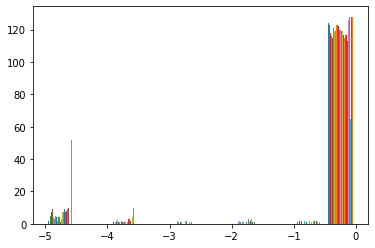

[[250. 250. 250. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]
 ...
 [  0.   0.   0. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]
 [250. 250. 250. ... 250. 250. 250.]]


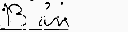

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


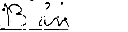

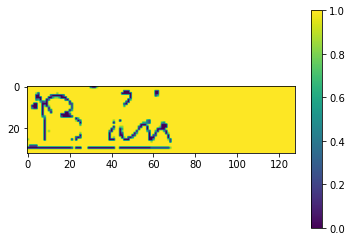

In [ ]:
print(vn_df.iloc[0][0])
img1 = np.array(vn_df.iloc[0][1].split(" "), dtype = float)#np.array([float(x) for x in vn_df.iloc[0][1].split(" ")])
img1 = img1.reshape(128, 32)
print(np.histogram(img1))
plt.hist(img1)
plt.show()
print((img1.T + -1*np.min(img1))*50)
cv2_imshow((img1.T + -1*np.min(img1))*50)
print(((img1.T+-1*np.min(img1))/(-1*np.min(img1))))
# cv2_imshow(((img1.T+-1*np.min(img1))/(-1*np.min(img1)))*255)
cv2_imshow(((img1.T/(-1*np.min(img1)))+1)*255)
img1 = (img1.T/(-1*np.min(img1))+1)*255
# plt.imshow(np.asarray(pd.to_numeric(vn_df.iloc[0][1])))
plt.imshow(img1/255.)
# plt.show()
plt.colorbar()

In [ ]:
vn_df.dropna(inplace=True)

In [ ]:
labels = []
images = []

for i in range(len(vn_df)):
  label = vn_df.iloc[i][0].strip()
  max_len_label = max(len(label), max_len_label)
  labels.append(label)
  img1 = np.array(vn_df.iloc[i][1].split(" "), dtype = float)
  img1 = img1.reshape(128, 32)
  img1 = img1.T/(-1*np.min(img1))+1    ## reverse-standardized and standardized again to suit the problem
  img1 = np.expand_dims(img1, axis=2)
  images.append(img1)

print(np.asarray(images).shape, np.asarray(labels).shape)
print(max_len_label)

(110734, 32, 128, 1) (110734,)
11


## Train-Test Split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(images, labels, train_size= 0.90, shuffle = True)
print(len(X_train), len(y_train), len(X_valid), len(y_valid))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size= 0.80, shuffle = True)

images = []
labels = []

99660 99660 11074 11074


In [ ]:
y_valid_enc = []
valid_input_len = []
y_valid_len = []

for value in y_valid:
  y_valid_enc.append(encode_to_labels(value))
  y_valid_len.append(len(value))
  valid_input_len.append(31)

print(y_valid[:5])

['kế', 'Quảng', 'lâu', 'nước', 'tư']


In [ ]:
y_train_enc = []
train_input_len = []
y_train_len = []

for value in y_train:
  y_train_enc.append(encode_to_labels(value))
  y_train_len.append(len(value))
  train_input_len.append(31)

print(y_train[:5])

['khả', 'phòng', 'một', 'nhờ', 'bí']


In [ ]:
# test_path = []
# test_label = []
# with open("/content/RWTH.iam_word_gt_final.test.thresh") as test_list:
#   for value in test_list:
#     test_path.append(value.split(",")[0].strip()+".png")
#     test_label.append(value.split(" ",1)[1].strip())

# # print(test_path)

# max_len_label = max(max_len_label,len(max(test_label, key=len)))
# # print(max_len_label)

## Padding the input sequences

In [12]:
y_train_padded = pad_sequences(y_train_enc, maxlen=max_len_label, padding='post', value = len(char_encoding))
y_valid_padded = pad_sequences(y_valid_enc, maxlen=max_len_label, padding='post', value = len(char_encoding))

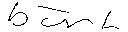

bình


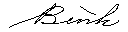

Bình


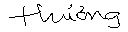

thương


In [13]:
cv2_imshow(X_train[0]*255)
print(y_train[0])

cv2_imshow(X_valid[0]*255)
print(y_valid[0])

cv2_imshow(X_test[5]*255)
print(y_test[5])

## Network Architecture

Based on [this](https://arxiv.org/pdf/1507.05717.pdf) paper and [this](https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-1/) blog.

In [14]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=256
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.3))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.3))(blstm_1)
 
outputs = Dense(len(char_encoding)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [15]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

## CTC Loss function

In [16]:
labels = Input(name='the_labels', shape=[max_len_label], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

## Training and Validation

In [17]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 
# filepath="best_model.hdf5"
filepath = "/content/drive/MyDrive/Kaggle/vn_best_model_binarized_256.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [18]:
X_train = np.array(X_train)
train_input_len = np.array(train_input_len)
y_train_len = np.array(y_train_len)

X_valid = np.array(X_valid)
valid_input_len = np.array(valid_input_len)
y_valid_len = np.array(y_valid_len)

In [19]:
X_test = np.array(X_test)

In [20]:
def train_initial(model,_epochs=10, _batch_size=64):
  model.fit(x=[X_train, y_train_padded, train_input_len, y_train_len], y=np.zeros(len(train_input_len)), batch_size=_batch_size, epochs = _epochs, validation_data = ([X_valid, y_valid_padded, valid_input_len, y_valid_len], [np.zeros(len(valid_input_len))]), verbose = 1, callbacks = callbacks_list)

def continue_training(model):
  model.load_weights("/content/drive/MyDrive/Kaggle/vn_best_model_binarized_256.hdf5")
  train_initial(model)

def transfer_learning(model,epochs=10, batch_size=64):
  model.load_weights("/content/drive/MyDrive/IAM_dataset/best_model_binarized_256.hdf5", by_name=True, skip_mismatch=True)
  train_initial(model, _epochs=epochs, _batch_size=batch_size)

In [21]:
# transfer_learning(model, epochs=20, batch_size=64)
train_initial(model, _epochs=20, _batch_size=64)

Epoch 1/20
1047/1047 [==============================] - ETA: 0s - loss: 9.0431
Epoch 1: val_loss improved from inf to 6.08600, saving model to /content/drive/MyDrive/Kaggle/vn_best_model_binarized_256.hdf5
1047/1047 [==============================] - 135s 109ms/step - loss: 9.0431 - val_loss: 6.0860
Epoch 2/20
1047/1047 [==============================] - ETA: 0s - loss: 3.5078
Epoch 2: val_loss improved from 6.08600 to 2.96046, saving model to /content/drive/MyDrive/Kaggle/vn_best_model_binarized_256.hdf5
1047/1047 [==============================] - 111s 106ms/step - loss: 3.5078 - val_loss: 2.9605
Epoch 3/20
1047/1047 [==============================] - ETA: 0s - loss: 2.2017
Epoch 3: val_loss improved from 2.96046 to 2.44114, saving model to /content/drive/MyDrive/Kaggle/vn_best_model_binarized_256.hdf5
1047/1047 [==============================] - 111s 106ms/step - loss: 2.2017 - val_loss: 2.4411
Epoch 4/20
1047/1047 [==============================] - ETA: 0s - loss: 1.7106
Epoch 4: v

In [ ]:
!nvidia-smi

In [ ]:
!ps -aux|grep python

In [22]:
## reducing RAM (colab issues)

X_train = []
y_train = []
X_valid = []
y_valid = []

## Testing

In [24]:
act_model.load_weights("/content/drive/MyDrive/Kaggle/vn_best_model_binarized_256.hdf5")

prediction = act_model.predict(X_test)

out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],greedy=True)[0][0])

predicted_labels = ["".join([char_encoding[x] for x in img if x != -1]) for img in out]
# print(["".join([char_encoding[x] for x in img if x != -1]) for img in out])
# print(predicted_labels[:10])

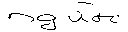

người
người


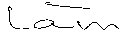

làm
làm


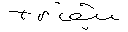

triệu
triệu


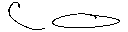

lo
lo


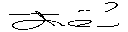

để
để


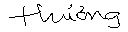

thương
thương


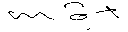

một
một


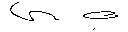

họ
họ


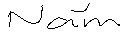

Năm
Năm


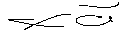

xã
xã


In [25]:
for i in range(10):
  cv2_imshow(X_test[i]*255)
  print(y_test[i])
  print(predicted_labels[i])

## Calculate Accuracy and CER

In [26]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.9 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149856 sha256=d2393be0b5a9daf2c4ae512282ec2b03f712f892feea94ed1f1478364a9f2c60
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [27]:
# cer = fastwer.score(test_label, predicted_labels , char_level=True)

from Levenshtein import distance

cer_each = []

# edit_distances_N = [distance(test_label[i], predicted_labels[i])/len(test_label[i]) for i in range(len(test_label))]    ## Need to calculate CER better.. edit_distance/(edit_distance+correct)
for i in range(len(y_test)):
  edit_dist = distance(y_test[i], predicted_labels[i])
  cer_each.append(edit_dist/(edit_dist+max(0,len(y_test[i])-edit_dist)))

# edit_distances_N = [distance(test_label[i], predicted_labels[i])/(distance(test_label[i], predicted_labels[i])+max(0,len(test_label[i])-distance(test_label[i], predicted_labels[i]))) for i in range(len(test_label))]
avg_cer = np.sum(cer_each)/len(cer_each)
print("Average CER:", avg_cer)

accuracy = np.sum(np.asarray(y_test) == np.asarray(predicted_labels))/len(y_test)
# print(np.sum(np.asarray(y_test) == np.asarray(predicted_labels)))
print("Accuracy: ", accuracy)#np.sum(np.asarray(y_test) == np.asarray(predicted_labels))/len(y_test))

Average CER: 0.08919250811347168
Accuracy:  0.7904439577941469
